# DC Loopback Test

## Get Pyro Instances

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time

from qick import *
from qick.averager_program import QickSweep, merge_sweeps
from qick.asm_v1 import QickRegister
from qick.pyro import make_proxy

# Qick version : 0.2.357
(soc, soccfg) = make_proxy("192.168.2.99")

Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
myqick PYRO:obj_3cde8b18d45b4d708deec1c942f4b4c0@192.168.2.99:34289


## Program

In [49]:
class DC_Loopback_Test(AveragerProgram):
    def initialize(self):
        # Declare DC generation channel
        self.declare_gen(
            ch      = 1,        # Channel
            nqz     = 1         # Nyquist Zone
        )
        # Declare DC input channel
        self.declare_readout(
            ch      = 2,        # Channel
            length  = self.cfg["pulse_time"] + 100       # Readout length
        )

        self.add_pulse(
            ch      = 1,
            idata   = [2 ** 15 - 2 for i in range(4800)],
            name    = "DAC5_pulse"
        )
        self.set_pulse_registers(
            ch      = 1,        # Generator channel
            style   = "arb",  # Output is gain * DDS output
            waveform= "DAC5_pulse",
            gain    = 10000,
            freq    = 0,
            phase   = 0
        )

        # Set ADC DDS
        self.set_readout_registers(
            ch      = 2,        # Readout channel
            freq    = 0, # Readout DDS frequency
            length  = self.cfg["pulse_time"],       # Readout DDS multiplication length
            phrst   = 0         # Readout DDS phase reset
        )
        self.synci(100)
    def body(self):
        self.pulse(
            ch      = 1,        # Generator channel
            t       = 100       # Pulse will be output @ sync_t + 100
        )
        self.readout(
            ch      = 2,        # Readout channel
            t       = 250       # Readout DDS will start multiplication
                                # @ sync_t + 100
        )
        self.trigger(
            adcs    = [2],      # Readout channels
            adc_trig_offset = 250 # Readout will capture the data @ sync_t + 50
        )
        self.sync_all()

## Execution


// Program

        regwi 1, $2, 0;                         //freq = 0
        regwi 1, $3, 0;                         //phase = 0
        regwi 1, $5, 10000;                     //gain = 10000
        regwi 1, $4, 0;                         //addr = 0
        regwi 1, $6, 17301804;                  //phrst| stdysel | mode | | outsel = 0b100001000 | length = 300 
        regwi 5, $12, 0;                        //freq = 0
        regwi 5, $16, 16777716;                 //mode | outsel = 0b100000000 | length = 500 
        synci 100;
        regwi 0, $15, 0;
        regwi 0, $14, 0;
LOOP_J: regwi 1, $7, 100;                       //t = 100
        set 0, 1, $2, $3, $4, $5, $6, $7;       //ch = 1, pulse @t = $7
        regwi 5, $17, 250;                      //t = 250
        set 6, 5, $12, $0, $16, $0, $16, $17;   //ch = 2, pulse @t = $17
        regwi 0, $16, 4;                        //out = 0b0000000000000100
        seti 7, 0, $16, 250;                    //ch =0 out = $16 @t = 0
  

  0%|          | 0/100 [00:00<?, ?it/s]

Acquisition time : %f 1.8366143703460693


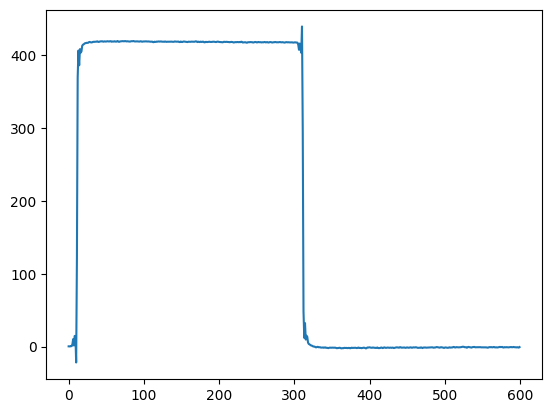

In [50]:
start_time = time.time()

cfg = {
    # Experiment Setup
    "reps"          : 1,
    # Parameter Setup
    "pulse_time"    : 500,
    "soft_avgs"     : 100
}
prog = DC_Loopback_Test(
    soccfg,
    cfg
)
print(prog)
data = prog.acquire_decimated(soc = soc, progress = True)
end_time = time.time()
print(f"Acquisition time : %f", end_time - start_time)
plt.figure()
plt.plot(data[0][0])
plt.show()